# Experiment A: Seed-level P_T and S_T Visualization

This simplified notebook focuses on three parts:
1) Imports & configuration
2) Minimal helpers to load event-level data grouped by seed
3) Visualization of P_T (path length) and S_T (AdaGrad energy) per seed with theory target overlays

In [1]:
# 1) Imports & configuration
import os
import glob
import json
import re
from typing import Dict, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
plt.style.use("seaborn-v0_8")

# Change to your latest sweep directory
BASE_DIR = "../results/grid_2025_08_31_p4/sweep"

In [2]:
# 2) Minimal helpers
def find_grid_cells(base_dir: str) -> List[str]:
    if not os.path.isdir(base_dir):
        return []
    return sorted([
        os.path.join(base_dir, d)
        for d in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, d))
    ])

def load_grid_params(grid_dir: str) -> dict:
    p = os.path.join(grid_dir, "params.json")
    if os.path.exists(p):
        try:
            with open(p, "r") as f:
                return json.load(f)
        except Exception:
            pass
    return {}

def _infer_seed_from_filename(path: str) -> Optional[int]:
    m = re.search(r"seed_(\d+)", os.path.basename(path))
    if m:
        try:
            return int(m.group(1))
        except Exception:
            return None
    return None

def _candidate_event_files(grid_dir: str) -> List[str]:
    # Prefer explicit event-level files if present
    ev = sorted(glob.glob(os.path.join(grid_dir, "seed_*_events.csv")))
    if ev:
        return ev
    # Fallback: seed_* CSVs that (after reading) look event-level
    return sorted(glob.glob(os.path.join(grid_dir, "seed_*.csv")))

def load_events_by_seed(grid_dir: str, usecols: Optional[List[str]] = None) -> Dict[int, pd.DataFrame]:
    files = _candidate_event_files(grid_dir)
    out: Dict[int, pd.DataFrame] = {}
    for p in files:
        try:
            df = pd.read_csv(p, usecols=usecols)
        except Exception:
            continue

        # Must look like event-level (multiple rows OR has 'event' column or per-step metrics)
        looks_event_level = (
            (len(df) > 1)
            or ("event" in df.columns)
            or ("P_T_true" in df.columns)
            or ("ST_running" in df.columns)
            or ("S_scalar" in df.columns)
        )
        if not looks_event_level:
            continue

        seed = _infer_seed_from_filename(p)
        if seed is None:
            # Try column if present
            if "seed" in df.columns:
                try:
                    seed = int(df["seed"].iloc[0])
                except Exception:
                    continue
            else:
                continue

        # Ensure a monotonically increasing step index if 'event' isn't present
        if "event" not in df.columns:
            df = df.copy()
            df["event"] = np.arange(len(df))

        df["seed"] = seed
        out[seed] = df
    return out

def _target_line(total_target: float, steps: int, T_total: int) -> np.ndarray:
    if not np.isfinite(total_target) or T_total <= 0 or steps <= 0:
        return np.array([])
    # Linear schedule from theory target allocated over horizon T_total
    return total_target * (np.arange(steps) / float(T_total))

def plot_pt_st_by_seed(grid_dir: str, max_seeds: Optional[int] = None) -> None:
    params = load_grid_params(grid_dir)
    data = load_events_by_seed(grid_dir)
    if not data:
        print(f"No event-level data found for: {os.path.basename(grid_dir)}")
        return

    # Optional limit on number of seeds plotted
    seeds = sorted(data.keys())
    if isinstance(max_seeds, int) and max_seeds > 0:
        seeds = seeds[:max_seeds]

    # Determine horizon for target overlays
    T_total = None
    for k in ["T", "max_events"]:
        if k in params and pd.notna(params[k]):
            try:
                T_total = int(params[k])
                break
            except Exception:
                pass
    if T_total is None:
        # Fallback to max length across seeds
        T_total = max(len(df) for df in data.values())

    target_PT = params.get("target_PT", np.nan)
    target_ST = params.get("target_ST", np.nan)

    # Prepare figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    title = os.path.basename(grid_dir)
    fig.suptitle(f"Seed-level P_T and S_T — {title}")

    # Left: P_T_true by seed
    ax = axes[0]
    any_pt = False
    for seed in seeds:
        df = data[seed]
        if "P_T_true" not in df.columns:
            continue
        steps = len(df)
        ax.plot(df["event"].values, df["P_T_true"].values, label=f"seed {seed}", alpha=0.9)
        # Target overlay per-seed length
        if np.isfinite(target_PT):
            pt_line = _target_line(target_PT, steps, T_total)
            if pt_line.size:
                ax.plot(df["event"].values[:len(pt_line)], pt_line, '--', color='black', alpha=0.5)
        any_pt = True
    ax.set_title("P_T (path length)")
    ax.set_xlabel("event")
    ax.set_ylabel("P_T_true")
    if any_pt:
        ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)

    # Right: S_T by seed (prefer ST_running; fallback to S_scalar)
    ax = axes[1]
    any_st = False
    for seed in seeds:
        df = data[seed]
        st_col = "ST_running" if "ST_running" in df.columns else ("S_scalar" if "S_scalar" in df.columns else None)
        if st_col is None:
            continue
        steps = len(df)
        ax.plot(df["event"].values, df[st_col].values, label=f"seed {seed}", alpha=0.9)
        # Target overlay per-seed length
        if np.isfinite(target_ST):
            st_line = _target_line(target_ST, steps, T_total)
            if st_line.size:
                ax.plot(df["event"].values[:len(st_line)], st_line, '--', color='black', alpha=0.5)
        any_st = True
    ax.set_title("S_T (AdaGrad energy)")
    ax.set_xlabel("event")
    ax.set_ylabel("S_T")
    if any_st:
        ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## 3) Run: pick a grid cell and plot seed-level P_T and S_T
- Update BASE_DIR above as needed
- Optionally change `grid_idx` or iterate over several cells

Visualizing: gamma_0.6-split_0.5_q0.95_k10_zcdp_rho0.5_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT100_ST40000_G2.00_lam0.05_c0.1-C10_h17566d84


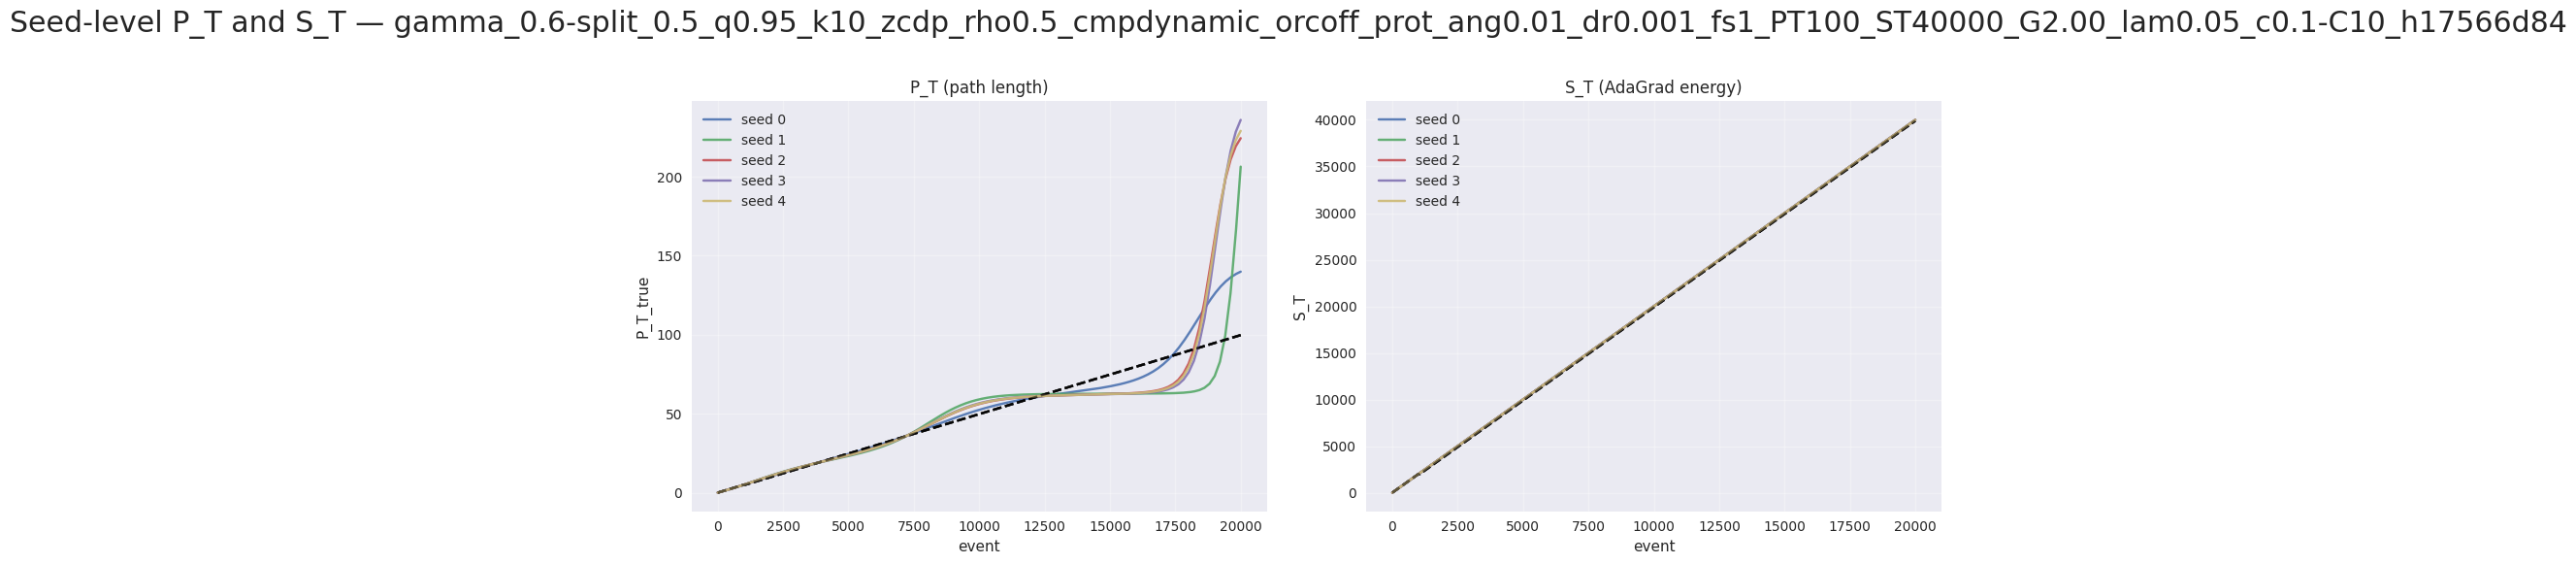

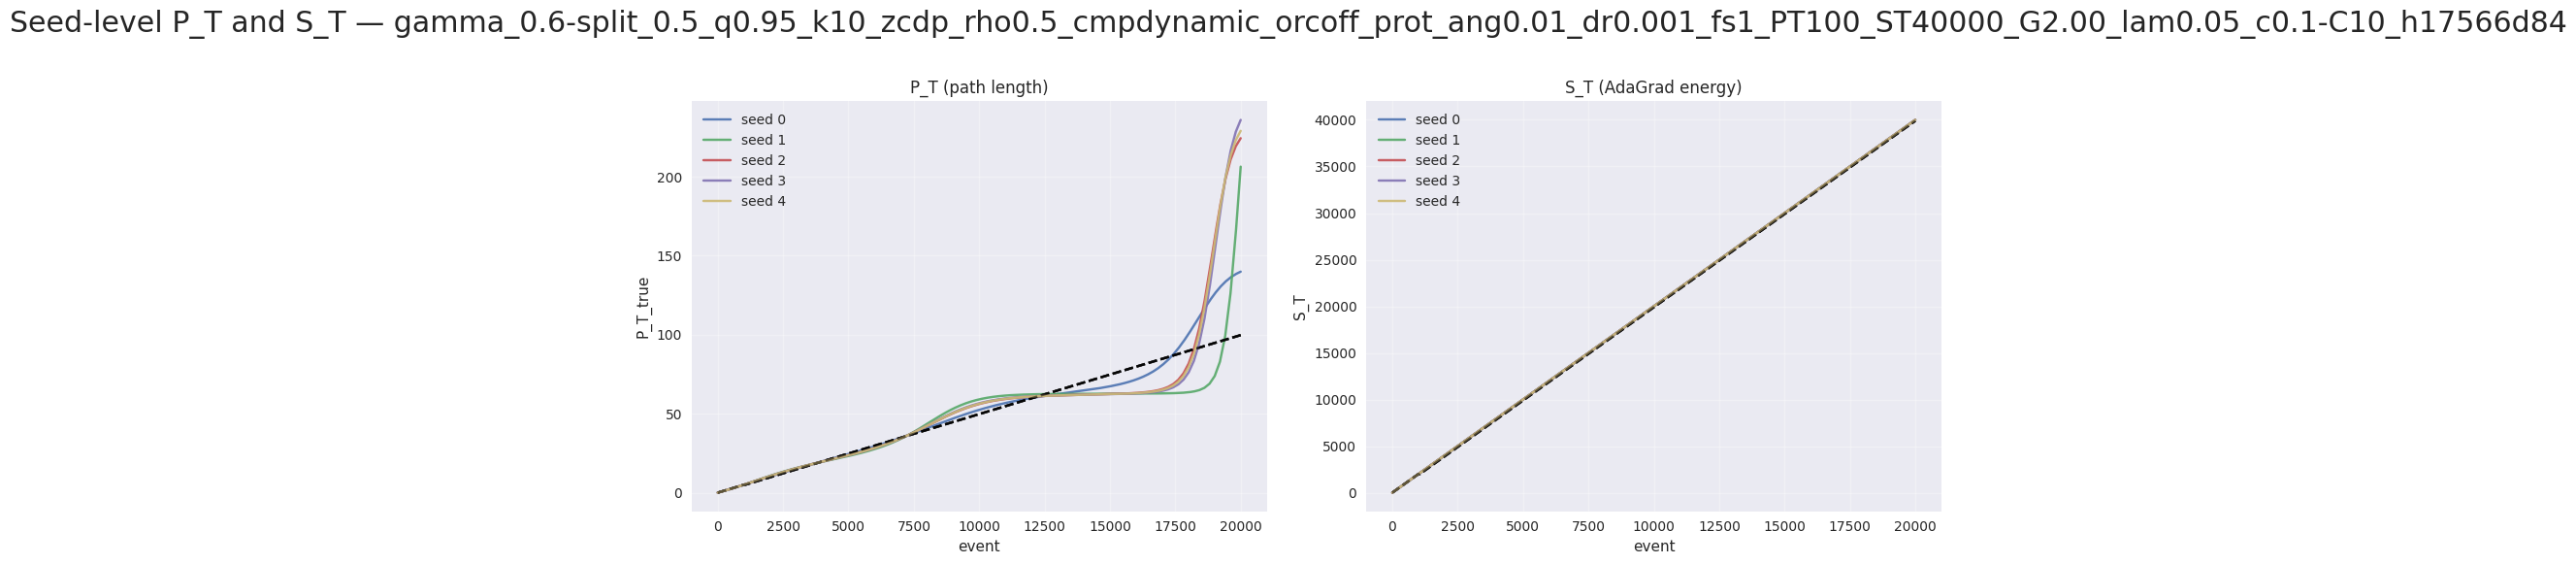

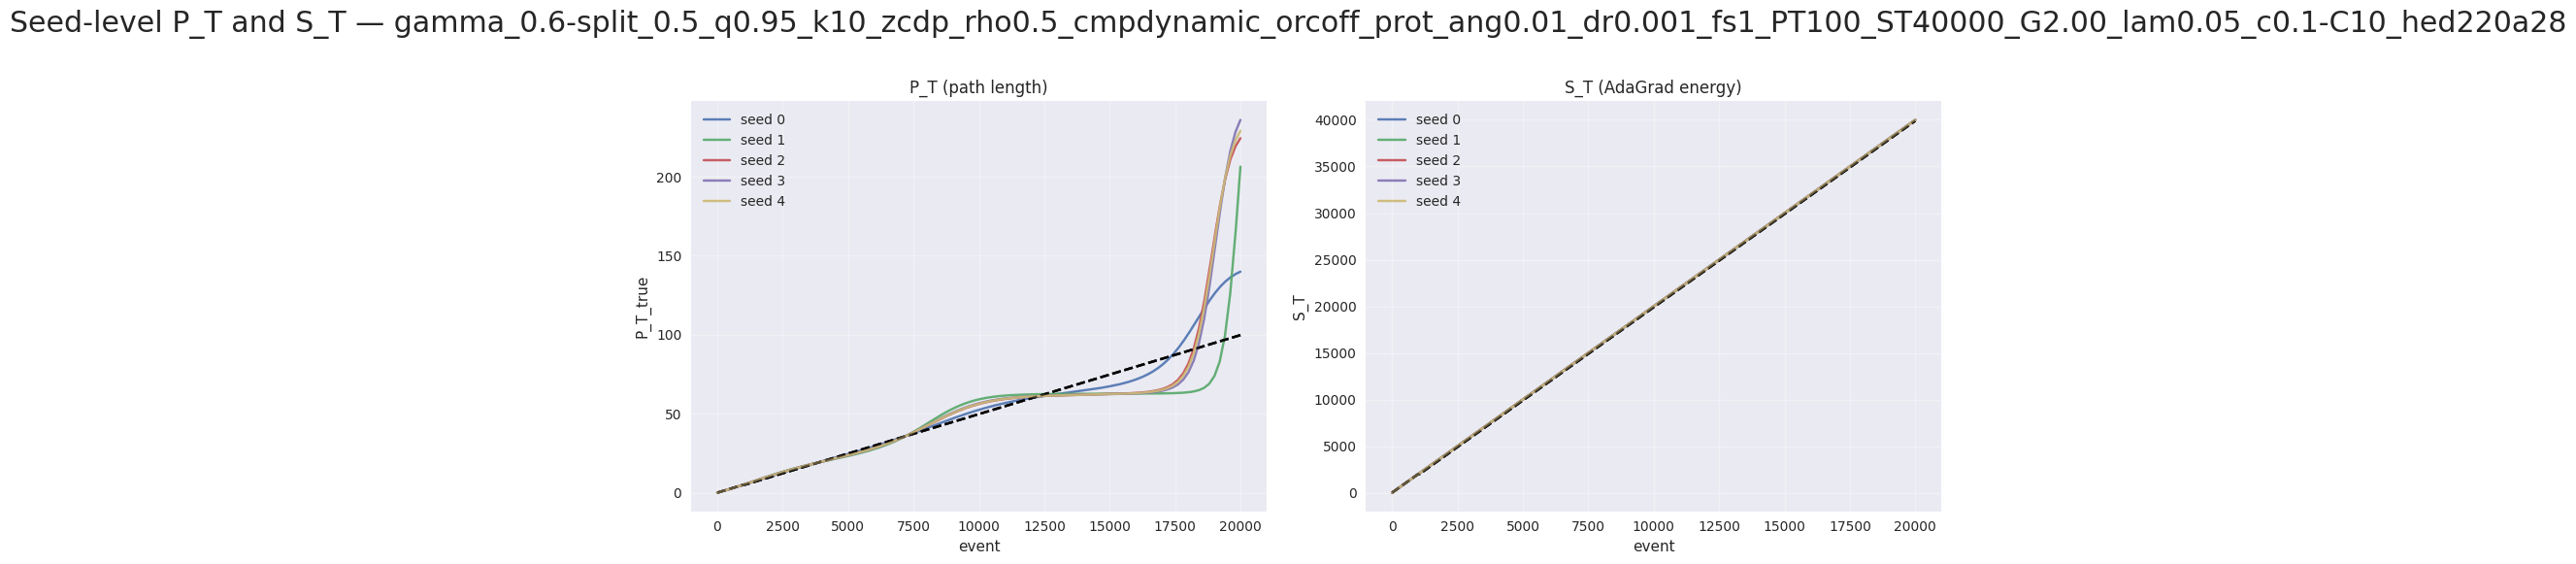

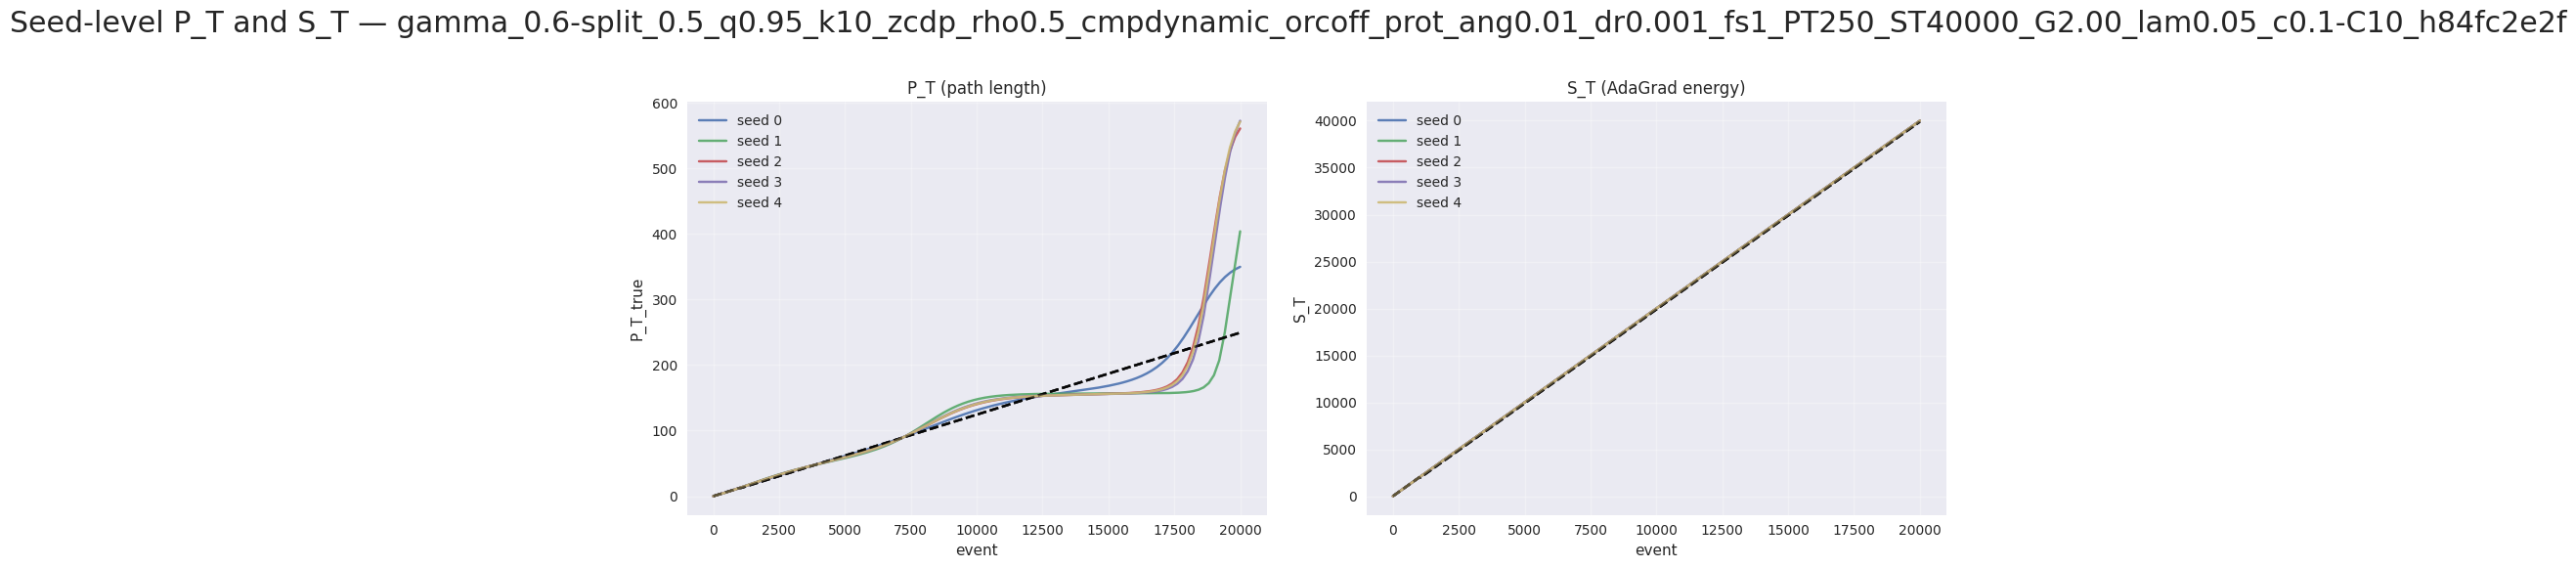

In [6]:
grid_dirs = find_grid_cells(BASE_DIR)
if not grid_dirs:
    print(f"No grid cells found under {BASE_DIR}")
else:
    # Choose one cell to visualize (change index as desired)
    grid_idx = 0
    grid_dir = grid_dirs[grid_idx]
    print(f"Visualizing: {os.path.basename(grid_dir)}")
    plot_pt_st_by_seed(grid_dir, max_seeds=None)

    for gd in grid_dirs[:3]:
        plot_pt_st_by_seed(gd)